In [15]:
import numpy as np
import pandas as pd
import math

#Model
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB, GaussianNB
from sklearn.pipeline import Pipeline
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.model_selection import cross_validate, GridSearchCV
from sklearn.metrics import confusion_matrix, accuracy_score, roc_auc_score
from sklearn.feature_selection import RFE

#Feature engineering, pipeline
from sklearn.preprocessing import StandardScaler, RobustScaler
from feature_engine.encoding import OneHotEncoder, CountFrequencyEncoder, OrdinalEncoder, RareLabelEncoder, MeanEncoder
from feature_engine import imputation as mdi
from feature_engine.discretisation import EqualFrequencyDiscretiser
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer

import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

#xgboost
import xgboost as xgb

In [16]:
# Load data
test = pd.read_csv('data_test_clean.csv')
#test=pd.read_csv('z_test.csv')

In [17]:
train = pd.read_csv('data_train_clean.csv')
#train = pd.read_csv('z_train.csv')

In [18]:
test.shape, train.shape

((3832, 11), (9995, 12))

In [19]:
# Manage data on train set
y_train = train['target']
X_train = train.drop(['enrollee_id', 'target'], axis=1)

# Manage data on test set
X_test = test.drop('enrollee_id', axis = 1)

In [20]:
y_train.shape, X_train.shape, X_test.shape

((9995,), (9995, 10), (3832, 10))

In [21]:
#RareLabelEncoder and replace with feature "city"

rare_encoder = RareLabelEncoder(tol = 0, n_categories = 4, variables = 'city', max_n_categories = 5, replace_with = 'Other')

In [22]:
X_train=rare_encoder.fit_transform(X_train)
X_test=rare_encoder.transform(X_test)

In [23]:
X_train.city.unique(), X_test.city.unique()

(array(['city_103', 'Other', 'city_114', 'city_21', 'city_160', 'city_16'],
       dtype=object),
 array(['city_160', 'Other', 'city_103', 'city_114', 'city_21', 'city_16'],
       dtype=object))

In [24]:
X_train['city'].replace({'city_103':'103','city_114':'114','city_21':'21','city_160':'160','city_16':'16'})

0         103
1       Other
2       Other
3         103
4         103
        ...  
9990      160
9991      103
9992    Other
9993      103
9994      103
Name: city, Length: 9995, dtype: object

In [25]:
X_train['city'].value_counts()

Other       4189
city_103    2610
city_21     1179
city_16      898
city_114     633
city_160     486
Name: city, dtype: int64

In [26]:
X_test['city'].replace({'city_103':'103','city_114':'114','city_21':'21','city_160':'160','city_16':'16'})

0         160
1       Other
2       Other
3       Other
4         103
        ...  
3827    Other
3828    Other
3829      160
3830    Other
3831      103
Name: city, Length: 3832, dtype: object

In [27]:
X_test['city'].value_counts()

Other       1710
city_103     858
city_21      546
city_16      274
city_114     269
city_160     175
Name: city, dtype: int64

In [28]:
# major discipline feature: replace

X_train['major_discipline']=np.where(X_train['major_discipline'] =='Humanities', 'Arts&Humanities', X_train['major_discipline'])

In [29]:
X_train['major_discipline']=np.where(X_train['major_discipline'] =='Arts', 'Arts&Humanities', X_train['major_discipline'])

In [30]:
X_test['major_discipline']=np.where(X_test['major_discipline'] =='Humanities', 'Arts&Humanities', X_test['major_discipline'])

In [31]:
X_test['major_discipline']=np.where(X_test['major_discipline'] =='Arts', 'Arts&Humanities', X_test['major_discipline'])

In [32]:
X_train['major_discipline'].value_counts()

STEM               8832
Arts&Humanities     593
Other               228
Business Degree     203
No Major            139
Name: major_discipline, dtype: int64

In [33]:
X_test['major_discipline'].value_counts()

STEM               2883
0                   576
Arts&Humanities     188
Other                73
Business Degree      68
No Major             44
Name: major_discipline, dtype: int64

In [34]:
#education level feature: replace

X_train['education_level']=np.where(X_train['education_level'] =='High School', 'School', X_train['education_level'])

In [35]:
X_train['education_level']=np.where(X_train['education_level'] =='Primary School', 'School', X_train['education_level'])

In [36]:
X_test['education_level']=np.where(X_test['education_level'] =='High School', 'School', X_test['education_level'])

In [37]:
X_test['education_level']=np.where(X_test['education_level'] =='Primary School', 'School', X_test['education_level'])

In [38]:
X_train['education_level'].value_counts()

Graduate    7126
Masters     2615
Phd          254
Name: education_level, dtype: int64

In [39]:
X_test['education_level'].value_counts()

Graduate    2333
Masters      847
School       476
0             91
Phd           85
Name: education_level, dtype: int64

In [40]:
#def city(x):
   # if x is np.nan:
        #return np.nan
    #return x.replace('city_', '')

In [41]:
#OneHotEncoder with features 'relevent_experience', 'gender', 'city', 'enrolled_university', 'education_level', 'major_discipline'

one_hot_encoder = OneHotEncoder(variables=['relevent_experience', 'gender', 'city', 'enrolled_university', 'education_level', 'major_discipline'], drop_last=False)

In [42]:
X_train=one_hot_encoder.fit_transform(X_train)
X_test=one_hot_encoder.transform(X_test)

In [43]:
#experience feature: Change to numeric and discretization

X_train['experience']=np.where(X_train['experience'] =='>20', '20', X_train['experience'])
X_train['experience']=np.where(X_train['experience'] =='<1', '0', X_train['experience'])

In [44]:
X_test['experience']=np.where(X_test['experience'] =='>20', '20', X_test['experience'])
X_test['experience']=np.where(X_test['experience'] =='<1', '0', X_test['experience'])

In [45]:
X_train['experience']=pd.to_numeric(X_train['experience'], errors='coerce')

In [46]:
X_test['experience']=pd.to_numeric(X_test['experience'], errors='coerce')

In [47]:
X_train['experience'].unique()

array([20, 15, 13,  7,  5, 16, 11,  0, 18, 19, 12, 10,  9,  4,  2,  6, 14,
        3,  8, 17,  1], dtype=int64)

Text(0, 0.5, 'Observaciones por contenedor')

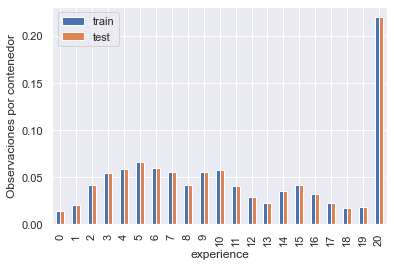

In [48]:
t1 = X_train.groupby(['experience'])['experience'].count()/len(X_train)
t2 = X_train.groupby(['experience'])['experience'].count()/len(X_train)

temp = pd.concat([t1, t2], axis=1)
temp.columns = ['train', 'test']
temp.plot.bar()
plt.ylabel('Observaciones por contenedor')

In [49]:
disc = EqualFrequencyDiscretiser(q=5, variables='experience')

In [50]:
X_train=disc.fit_transform(X_train)
X_test=disc.transform(X_test)

In [51]:
X_train.experience.value_counts()

3    3855
0    2540
2    2039
1    1561
Name: experience, dtype: int64

In [52]:
X_test.experience.value_counts()

0    1311
3    1201
2     723
1     597
Name: experience, dtype: int64

In [53]:
#train experience = train experience .fillna (train experience mean)

In [54]:
#last new job feature: Change to numeric

X_train['last_new_job']=np.where(X_train['last_new_job'] =='>4', '5', X_train['last_new_job'])
X_train['last_new_job']=np.where(X_train['last_new_job'] =='never', '0', X_train['last_new_job'])

In [55]:
X_test['last_new_job']=np.where(X_test['last_new_job'] =='>4', '5', X_test['last_new_job'])
X_test['last_new_job']=np.where(X_test['last_new_job'] =='never', '0', X_test['last_new_job'])

In [56]:
X_train['last_new_job']=pd.to_numeric(X_train['last_new_job'], errors='coerce')

In [57]:
X_test['last_new_job']=pd.to_numeric(X_test['last_new_job'], errors='coerce')

In [58]:
#data_z_train['experience'] = pd.get_dummies(data_z_train['experience'], drop_first = True)
#data_z_train['company_size'] = pd.get_dummies(data_z_train['company_size'], drop_first = True)
#data_z_train['company_type'] = pd.get_dummies(data_z_train['company_type'], drop_first = True)
#data_z_train['last_new_job'] = pd.get_dummies(data_z_train['last_new_job'], drop_first = True)
#data_z_train['education_level'] = pd.get_dummies(data_z_train['education_level'], drop_first = True)
#data_z_train['relevent_experience'] = pd.get_dummies(data_z_train['relevent_experience'], drop_first = True)
#data_z_train['enrolled_university'] = pd.get_dummies(data_z_train['enrolled_university'], drop_first = True)

In [59]:
X_train.dtypes

city_development_index                         float64
experience                                       int64
last_new_job                                     int64
training_hours                                   int64
relevent_experience_Has relevent experience      int32
relevent_experience_No relevent experience       int32
gender_Male                                      int32
gender_Female                                    int32
gender_Other                                     int32
city_city_103                                    int32
city_Other                                       int32
city_city_114                                    int32
city_city_21                                     int32
city_city_160                                    int32
city_city_16                                     int32
enrolled_university_no_enrollment                int32
enrolled_university_Part time course             int32
enrolled_university_Full time course             int32
education_

In [60]:
X_test.dtypes

city_development_index                         float64
experience                                       int64
last_new_job                                     int64
training_hours                                   int64
relevent_experience_Has relevent experience      int32
relevent_experience_No relevent experience       int32
gender_Male                                      int32
gender_Female                                    int32
gender_Other                                     int32
city_city_103                                    int32
city_Other                                       int32
city_city_114                                    int32
city_city_21                                     int32
city_city_160                                    int32
city_city_16                                     int32
enrolled_university_no_enrollment                int32
enrolled_university_Part time course             int32
enrolled_university_Full time course             int32
education_

In [61]:
# Normalize data
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [62]:
# GridSearchCV with XGBoost model
xgb_model = xgb.XGBClassifier(random_state=42)
param_grid = {'objective':['binary:logistic'],
              'learning_rate': [0.001,0.05,0.1, 10], 
              'max_depth': [2,3,4,5,6],
              'min_child_weight': [11],
              'subsample': [0.8],
              'colsample_bytree': [0.7],
              'n_estimators': [1000]}
#

In [63]:
grid = GridSearchCV(estimator = xgb_model, cv=5, param_grid = param_grid , scoring = 'roc_auc', verbose = 1, n_jobs = -1, refit=True)
grid.fit(X_train,y_train)

Fitting 5 folds for each of 20 candidates, totalling 100 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:  2.9min
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:  6.5min finished
C:\Users\Anna\Anaconda3\envs\ironhack\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[17:43:17] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


GridSearchCV(cv=5,
             estimator=XGBClassifier(base_score=None, booster=None,
                                     colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=None, gamma=None,
                                     gpu_id=None, importance_type='gain',
                                     interaction_constraints=None,
                                     learning_rate=None, max_delta_step=None,
                                     max_depth=None, min_child_weight=None,
                                     missing=nan, monotone_constraints=None,
                                     n_estimators=100, n_jobs...
                                     reg_alpha=None, reg_lambda=None,
                                     scale_pos_weight=None, subsample=None,
                                     tree_method=None, validate_parameters=None,
                                     verbosity=None),
  

In [64]:
print("Best Score:" + str(grid.best_score_))

Best Score:0.748181187753954


In [65]:
print("Best Parameters: " + str(grid.best_params_))

Best Parameters: {'colsample_bytree': 0.7, 'learning_rate': 0.001, 'max_depth': 6, 'min_child_weight': 11, 'n_estimators': 1000, 'objective': 'binary:logistic', 'subsample': 0.8}


In [66]:
best_parameters = grid.best_params_
best_parameters

{'colsample_bytree': 0.7,
 'learning_rate': 0.001,
 'max_depth': 6,
 'min_child_weight': 11,
 'n_estimators': 1000,
 'objective': 'binary:logistic',
 'subsample': 0.8}

In [67]:
# XGBoost model with RFE
xgb_model = xgb.XGBClassifier(**best_parameters)
xgb_model.fit(X_train,y_train)

selector = RFE(xgb_model, 200, step=1)
selector.fit(X_train,y_train)

[17:43:36] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\Anna\Anaconda3\envs\ironhack\lib\site-packages\sklearn\utils\validation.py:70: FutureWarning: Pass n_features_to_select=200 as keyword args. From version 0.25 passing these as positional arguments will result in an error
  FutureWarning)
C:\Users\Anna\Anaconda3\envs\ironhack\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[17:43:45] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


RFE(estimator=XGBClassifier(base_score=0.5, booster='gbtree',
                            colsample_bylevel=1, colsample_bynode=1,
                            colsample_bytree=0.7, gamma=0, gpu_id=-1,
                            importance_type='gain', interaction_constraints='',
                            learning_rate=0.001, max_delta_step=0, max_depth=6,
                            min_child_weight=11, missing=nan,
                            monotone_constraints='()', n_estimators=1000,
                            n_jobs=4, num_parallel_tree=1, random_state=0,
                            reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
                            subsample=0.8, tree_method='exact',
                            validate_parameters=1, verbosity=None),
    n_features_to_select=200)

In [68]:
#predict results
y_predict = selector.predict(X_test)

print(y_predict)

[0. 0. 0. ... 0. 0. 0.]


In [69]:
pd.Series(y_predict).value_counts()

0.0    3205
1.0     627
dtype: int64

In [70]:
len(y_predict)

3832

In [71]:
#predict results with X_train

y_predict_train = selector.predict(X_train)

In [72]:
pd.Series(y_predict_train).value_counts()

0.0    8708
1.0    1287
dtype: int64

In [73]:
confusion_matrix(y_train, y_predict_train)

array([[7142,  486],
       [1566,  801]], dtype=int64)

In [74]:
auc=roc_auc_score(y_train, y_predict_train)
print(auc)

0.6373452020871673


In [75]:
# GridSearchCV with LogisticRegressor model
lr = LogisticRegression(random_state=42)
param_grid = {'class_weight' : ['balanced', None], 
              'penalty' : ['l2','l1'], 
              'C' : [0.001, 0.01, 0.1, 1, 10, 100],
              'solver': ['saga']}

In [76]:
grid = GridSearchCV(estimator = lr, cv=5, param_grid = param_grid , scoring = 'roc_auc', verbose = 1, n_jobs = -1)

In [77]:
grid.fit(X_train,y_train)

Fitting 5 folds for each of 24 candidates, totalling 120 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    2.5s
[Parallel(n_jobs=-1)]: Done 120 out of 120 | elapsed:   15.1s finished


GridSearchCV(cv=5, estimator=LogisticRegression(random_state=42), n_jobs=-1,
             param_grid={'C': [0.001, 0.01, 0.1, 1, 10, 100],
                         'class_weight': ['balanced', None],
                         'penalty': ['l2', 'l1'], 'solver': ['saga']},
             scoring='roc_auc', verbose=1)

In [78]:
print("Best Score:" + str(grid.best_score_))
print("Best Parameters: " + str(grid.best_params_))

Best Score:0.7471658723536583
Best Parameters: {'C': 0.01, 'class_weight': None, 'penalty': 'l2', 'solver': 'saga'}


In [79]:
best_parameters = grid.best_params_

In [80]:
# LogisticRegression with RFE and 150 features
lr = LogisticRegression(**best_parameters)

In [81]:
lr.fit(X_train,y_train)

LogisticRegression(C=0.01, solver='saga')

In [82]:
selector = RFE(lr, 200, step=1)
selector.fit(X_train,y_train)

C:\Users\Anna\Anaconda3\envs\ironhack\lib\site-packages\sklearn\utils\validation.py:70: FutureWarning: Pass n_features_to_select=200 as keyword args. From version 0.25 passing these as positional arguments will result in an error
  FutureWarning)


RFE(estimator=LogisticRegression(C=0.01, solver='saga'),
    n_features_to_select=200)

In [83]:
#predict results
y_predict_lr = selector.predict(X_test)

print(y_predict_lr)

[0. 0. 0. ... 0. 0. 0.]


In [93]:
pd.Series(y_predict_lr).value_counts()

0.0    3218
1.0     614
dtype: int64

In [94]:
#predict results with X_train

y_predict_train = selector.predict(X_train)

In [95]:
confusion_matrix(y_train, y_predict_train)

array([[7141,  487],
       [1635,  732]], dtype=int64)

In [96]:
auc=roc_auc_score(y_train, y_predict_train)
print(auc)

0.6227042421922303


In [97]:
# Combine models
final_preds = (y_predict_lr * 0.8 + y_predict * 0.2)

Preparation of submission file

In [98]:
my_submission = pd.DataFrame({'enrollee_id': test.enrollee_id, 'target': final_preds})
my_submission

,enrollee_id,target
0,23603,0.0
1,22499,0.0
2,10465,0.0
3,8293,0.0
4,4246,0.0
...,...,...
3827,8880,0.0
3828,7886,0.0
3829,12279,0.0
3830,5326,0.0


In [99]:
my_submission.target.value_counts()

0.0    3218
1.0     614
Name: target, dtype: int64

In [92]:
my_submission.shape[0]

3832

In [358]:
# you could use any filename. We choose submission here
my_submission.to_csv('submission.csv', index=False)

In [ ]:
# New score: 63%

In [ ]:
#1. Datacleaning
#2. RFE & Deepforest

In [ ]:
#x_train.isnull().sum()[x_train.isnull().sum() > 0]

In [ ]:
#solo variables numericos
#data_z_train['company_type'] = data_z_train['company_type'].fillna(data_z_train['company_type'].mean())
#data_z_train['company_size'] = data_z_train['company_size'].fillna(data_z_train['company_size'].mean())
#data_z_train['gender'] = data_z_train['gender'].fillna(data_z_train['gender'].mean())
#data_z_train['major_discipline'] = data_z_train['major_discipline'].fillna(data_z_train['major_discipline'].mean())
#data_z_train['education_level'] = data_z_train['education_level'].fillna(data_z_train['education_level'].mean())
#data_z_train['last_new_job'] = data_z_train['last_new_job'].fillna(data_z_train['last_new_job'].mean())
#data_z_train['enrolled_university'] = data_z_train['enrolled_university'].fillna(data_z_train['enrolled_university'].mean())
#data_z_train['experience'] = data_z_train['experience'].fillna(data_z_train['experience'].mean())

In [ ]:
#def gender(x):
   # gender_dict = {'Female': 2, 'Male': 1, 'Other': 0}
  #  if x is np.nan:
   #     return np.nan
   # return gender_dict[x]
    
#def relevent_experience(x):
   # rel_experience_dict = {'Has relevent experience': 1, 'No relevent experience': 0}
   # if x is np.nan:
       # return np.nan
   # return rel_experience_dict[x]